# PCA component discriminability

In [3]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
from scipy import stats as sstats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy
cmap = cm.jet
import math
from sklearn.datasets import load_iris
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import cross_val_score
import random
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")

In [4]:
# define mouse information, and preprocessin versions from analysis.
# load data for all sessions in this mouse and compute mean activity for each neuron.

mouse = 56165        ### mouse number id
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 20  ### 100 means everything was aligned, 200 means it was also equalized, 20 is for day wise
alignment_v = 3           ## alignment version, version 3 is for day wise
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version

# here we will do analysis with no registration
# registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf= 1                 ## value of resampling
session_now = 1
BINS = 70
period = int(5 * sf / re_sf)
period_resting = period *50
fixed = 'None'
## define task for plotting. This will cahnge for other mice!!!!

if mouse == 56165 or mouse == 32364:
    if mouse == 56165:
        sessions = [1,2,4]       ## sessions for this particular mouse
    if mouse == 32364:
        sessions = [1,2]
    if session_now == 1:
        task = 'OVERLAPPING'
        colapse_behaviour = 1
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        if mouse == 32364:
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   
        if mouse == 56165:
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   

    else:
        if session_now == 2:
            task = 'STABLE'
            colapse_behaviour = 2
            labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        else:
            task = 'RANDOM'
            colapse_behaviour = 0
            labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32365:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 2:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 3:
            task = 'OVERLAPPING'
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]           
            
if mouse == 56166:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]

    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32366:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 3:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32363:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'
            object_fixed = 6
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]

In [5]:
file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_day_wise/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
behaviour_dir_parameters = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram_parameters/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
tracking_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/center_of_mass/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/figures/ROC/'

In [6]:
# define all relevant files names and load them into a list
session = session_now

activity_list = []
timeline_list = []
behaviour_list = []
behaviour_list_copy = []
behaviour_list_unsup = []
parameters_list = []
tracking_list = []
total_time = 0
day = 0
print('LOADING TRIALS ACTIVITY AND CREATING LIST OF ACTIVITY, TRACKING AND BEHAVIOUR')
for trial in [1,6,11,16]:

    beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75_ethogram.npy'
    ## LOAD BEHAVIOUR
    behaviour = np.load(behaviour_dir + beh_file_name_1)
    reshape_behaviour = np.reshape(behaviour[:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
    resample_beh1 = np.reshape(scipy.stats.mode(reshape_behaviour,axis=1)[0],reshape_behaviour.shape[0])

    beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75_parameters.npy'
    ## LOAD PARAMETRS FOR BEHAVIOUR CLASSIFICATION
    parameters = np.load(behaviour_dir_parameters + beh_file_name_1)
    params = []
    for param in range(parameters.shape[0]):
        r1_params = np.reshape(parameters[param,:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
        r2_params = np.reshape(scipy.stats.mode(r1_params,axis=1)[0],reshape_behaviour.shape[0])
        params.append(r2_params)
    resample_params = np.array(params)
        
    ## LOAD TRACKING
    tracking_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75.npy'
    position = np.load(tracking_dir + tracking_file_name_1)
    resample_position, resample_position_stc = stats.resample_matrix(neural_activity=position.T,
                                                                                            re_sf=re_sf)
    ## LOAD TIMELINE
    time_file_session_1 =  'mouse_'+ f'{mouse}'+'_session_'+ f'{session}' +'_trial_'+ f'{trial}'+'_v1.3.1.0_10.pkl'

    timeline_file= open(timeline_file_dir + time_file_session_1,'rb')
    timeline_info = pickle.load(timeline_file)
    timeline_1 = np.zeros(len(timeline_info) + 1)
    for i in range(len(timeline_info)):
        timeline_1[i] = timeline_info[i][1]
    timeline_1[len(timeline_info)] = behaviour.shape[0]
    timeline = timeline_1/re_sf
    time_lenght = 10
    resample_timeline = timeline_1/re_sf
    timeline_list.append(resample_timeline)

    behaviour_list.append(resample_beh1)
    behaviour_list_copy.append(resample_beh1.copy())
    resample_params_ = np.zeros((resample_params.shape[0]+1,resample_params.shape[1]))
    resample_params_[0,:] = np.arange(0,resample_params.shape[1])
    resample_params_[1:,:] = resample_params
    parameters_list.append(resample_params_)
    tracking_list.append(resample_position)
    total_time = total_time + behaviour.shape[0]


    file_name_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_'+ f'{trial}'+'_v' + f'{decoding_v}' + '.4.' + f'{motion_correction_v}' + \
                            '.' + f'{alignment_v}' + '.' + f'{equalization_v}' + '.' + f'{source_extraction_v}' + '.' + \
                          f'{component_evaluation_v}' +  '.0.npy'

     ##load activity and timeline
    activity = np.load(file_directory + file_name_session_1)
    neural_activity1 = activity[1:,:]
    ## z-score neural activity
    neural_activity = neural_activity1
    ##downsample neural activity
    resample_neural_activity_mean, resample_neural_activity_std = stats.resample_matrix(neural_activity=neural_activity,
                                                                                            re_sf=re_sf)

    activity_list.append(resample_neural_activity_mean)

    day = day + 1
    print(day)
    
id_target = [0,1,2,3,4,5,6] # 0: unlabeled, 1:resting, 2:Navigation, 3: Obj1, 4:Obj2, 5:Run1, 6:Run2

if colapse_behaviour == 0 : # RANDOM
    for day in range(len(behaviour_list)):
        for trial in range(5):
            behaviour_trial = behaviour_list[day][int(timeline_list[day][2*trial]):int(timeline_list[day][2*trial+1])]
            objects = np.unique(behaviour_trial)
            selected_object = np.random.randint(len(objects)-4,len(objects)-2,1)
            index0 = np.where(behaviour_trial==objects[selected_object])[0]
            index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-4], behaviour_trial!=objects[selected_object]))
            index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-3], behaviour_trial!=objects[selected_object]))
            behaviour_trial[index0] = 3
            behaviour_trial[index1] = 4
            behaviour_trial[index2] = 4            
            
            index0 = np.where(behaviour_trial==objects[selected_object]+4)[0]
            index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-2], behaviour_trial!=objects[selected_object]+4))
            index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-1], behaviour_trial!=objects[selected_object]+4))
            behaviour_trial[index0] = 5
            behaviour_trial[index1] = 6
            behaviour_trial[index2] = 6 
            
            behaviour_list[day][int(timeline_list[day][2*trial]):int(timeline_list[day][2*trial+1])] = behaviour_trial


if colapse_behaviour == 1 : #OVERLAPPING
    for day in range(len(behaviour_list)):
        behaviour_list[day][np.where(behaviour_list[day] == object_fixed)[0]] = 100
        behaviour_list[day][np.where(np.logical_and(behaviour_list[day]>=3, behaviour_list[day]<=6))[0]] = 4
        behaviour_list[day][np.where(behaviour_list[day] == 100)[0]] = 3        
        behaviour_list[day][np.where(behaviour_list[day] == object_fixed +4)[0]] = 200        
        behaviour_list[day][np.where(np.logical_and(behaviour_list[day]>=7, behaviour_list[day]<=10))[0]] = 6
        behaviour_list[day][np.where(behaviour_list[day] == 200)[0]] = 5        


if colapse_behaviour == 2: #STABLE
    for day in range(len(behaviour_list)):
        objects = np.unique(behaviour_list[day])
        selected_object = np.random.randint(len(objects)-4,len(objects)-2,1)
        index0 = np.where(behaviour_list[day]==objects[selected_object])[0]
        index1 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-4], behaviour_list[day]!=objects[selected_object]))
        index2 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-3], behaviour_list[day]!=objects[selected_object]))
        behaviour_list[day][index0] = 3
        behaviour_list[day][index1] = 4
        behaviour_list[day][index2] = 4      
    
        index0 = np.where(behaviour_list[day]==objects[selected_object]+4)[0]
        index1 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-2], behaviour_list[day]!=objects[selected_object]+4))
        index2 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-1], behaviour_list[day]!=objects[selected_object]+4))
        behaviour_list[day][index0] = 5
        behaviour_list[day][index1] = 6
        behaviour_list[day][index2] = 6  

LOADING TRIALS ACTIVITY AND CREATING LIST OF ACTIVITY, TRACKING AND BEHAVIOUR
1
2
3
4


In [5]:
print(resample_params.shape)

(13, 30905)


In [9]:
pca = PCA()
activity_list_pca = []
variance_list = []
variance_ratio_list = []

cca_components = min(13,activity_list[day].shape[0])
cca = CCA(n_components=cca_components)
activity_list_cca = []

for day in range(len(behaviour_list)):
    ### run pca on the entire dataset
    pca.fit(activity_list[day].T)
    transformed_activity = pca.fit(activity_list[day].T).transform(activity_list[day].T)
    activity_list_pca.append(transformed_activity.T)
    variance_list.append(pca.explained_variance_/(1+np.sqrt(activity_list[day].shape[0]/activity_list[day].shape[1]))**2)
    normalized_variance = pca.explained_variance_/(1+np.sqrt(activity_list[day].shape[0]/activity_list[day].shape[1]))**2
    variance_ratio_list.append(np.cumsum(normalized_variance/sum(normalized_variance)))
    activity_list_cca.append(cca.fit(activity_list[day].T, parameters_list[day].T).transform(activity_list[day].T))
    

In [10]:
# for each day creates a list that counts and saves times of different events.
events_day_list = []
events_counter_day_list = []
events_time_starts_day = []
for day in range(len(behaviour_list)):
    events_list = []
    events_counter_list = []
    events_time_starts = []
    random_events = []
    start_counter = 100
    counter = 0
    for i in range(behaviour_list[day].shape[0]):
        if behaviour_list[day][i] != start_counter:
            events_list.append(start_counter)
            events_counter_list.append(counter)
            events_time_starts.append(i)
            start_counter = behaviour_list[day][i]
            counter = 1
        else:
            counter = counter + 1      
    events_day_list.append(events_list)
    events_counter_day_list.append(events_counter_list)
    events_time_starts_day.append(events_time_starts)

In [11]:

## put all events together and take neural activity from each event
events_activity_pre_norm= []
events_duration_list = []
events_activity_pca = []
events_activity_cca = []


for day in range(len(behaviour_list)):
    target_activity = []
    target_activity_pca = []
    target_activity_cca = []
    events_duration_day = []
    for target in id_target:
        events = np.array(events_day_list[day])
        events_counter = np.array(events_counter_day_list[day])
        events_time = np.array(events_time_starts_day[day])

        position_events = np.where(events == target)[0]
        events_duration = events_counter[position_events]   # convert to seconds
        time = events_time[position_events]
        i = 0
        event_target = []
        event_target_pca = []
        event_target_cca = []
        events_duration_target = np.zeros(len(events_duration),)
        for event in events_duration:
            if event > 10:
                local_activity = activity_list[day][:,time[i]-period:time[i]+period]
                local_activity_pca = activity_list_pca[day][:,time[i]-period:time[i]+period]
                local_activity_cca = activity_list_cca[day][time[i]-period:time[i]+period,:].T
                event_target.append(local_activity)
                event_target_pca.append(local_activity_pca)
                event_target_cca.append(local_activity_cca)
                events_duration_target[i]=1
            i = i + 1
        target_activity.append(event_target)
        target_activity_pca.append(event_target_pca)
        target_activity_cca.append(event_target_cca)
        events_duration_day.append(events_duration_target)
    events_activity_pre_norm.append(target_activity)
    events_duration_list.append(events_duration_day)
    events_activity_pca.append(target_activity_pca)
    events_activity_cca.append(target_activity_cca)



In [12]:
# z-score the traces
events_activity = []
for day in range(len(behaviour_list)):
    target_activity = []
    for target in id_target:
        mean_z_score = np.mean(events_activity_pre_norm[day][target],axis=0)
        #print(mean_z_score.shape)
        std_z_score = np.std(events_activity_pre_norm[day][target],axis=0)
        events_target = []
        for event in range(len(events_activity_pre_norm[day][target])):
            new_activity = (events_activity_pre_norm[day][target][event]-mean_z_score)/std_z_score
            #new_activity = events_activity_pre_norm[day][target][event]
            events_target.append(new_activity)
        target_activity.append(events_target)
    events_activity.append(target_activity)

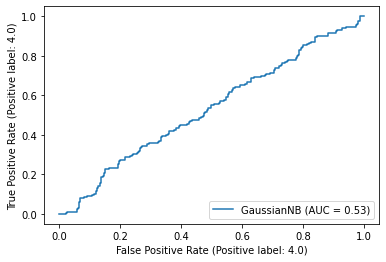

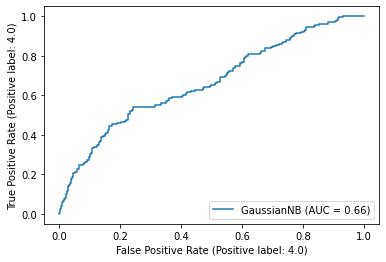

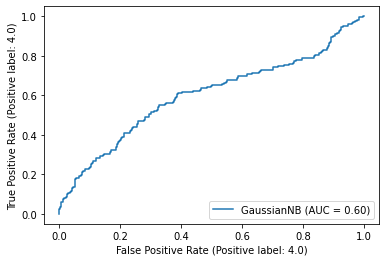

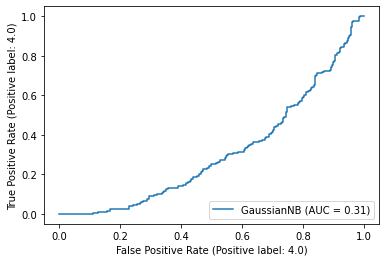

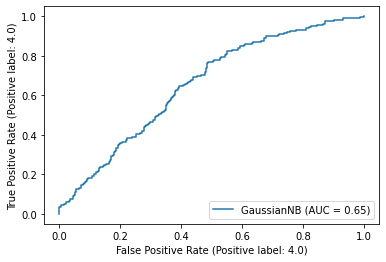

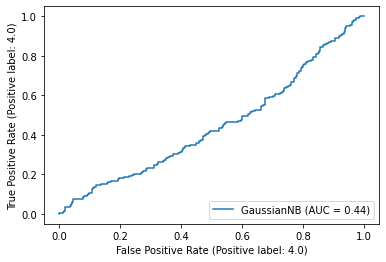

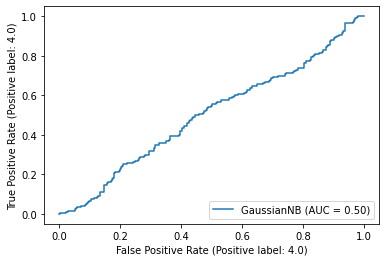

In [19]:
   
    ###DAY TRAINING!!!!!!!!!!!!!!!1
    ###spatial prediction     
    from sklearn.model_selection import train_test_split
    from sklearn.naive_bayes import GaussianNB
    from sklearn.metrics import RocCurveDisplay
    
    day = 1
    gnb = GaussianNB()
    
    Xpre_all = activity_list[day].T
    FR_limit = 12
    ###canonical correlations analysis
    dim = 2
    kfold_number = 2
    kf = KFold(n_splits=kfold_number)

    ### select in track part of experiment where there is exploration
    index_track = np.logical_and(behaviour_list[day]>2,behaviour_list[day]<5)
    ybehaviour = behaviour_list[day][index_track]
    yparameters = parameters_list[day][:,index_track]
    Xpre_day = Xpre_all[index_track,:]
    # selected_temporal_bins for preserving class balance (here classes are not balanced)
    selected_temporal_bins = np.arange(0,Xpre_day.shape[0])
    X_day = Xpre_day[selected_temporal_bins,:]
    ybehaviour_day = ybehaviour[selected_temporal_bins]
    yparameters_day = yparameters[:,selected_temporal_bins]
    
    cca_components = min(14,X_day.shape[1])
    cca = CCA(n_components=cca_components)

    ### train a decoder in the cca + gnb
    #for train_index, test_index in kf.split(X_day):

    ### manual splitting 
    
    training_data = int(np.floor(X_day.shape[0]/10)*9)
    X_train_cca = X_day[0:training_data,:]
    X_test_cca = X_day[training_data:,:]
    y_train_cca = yparameters_day[:,0:training_data].T
    y_test_cca = yparameters_day[:,training_data:].T
    y_train_gnb = ybehaviour_day[0:training_data]
    y_test_gnb = ybehaviour_day[training_data:]
    
#         X_train_cca, X_test_cca = X_day[train_index], X_day[test_index]
#         y_train_cca, y_test_cca = yparameters_day[:,train_index], yparameters_day[:,test_index]
        
#         y_train_gnb, y_test_gnb = ybehaviour_day[train_index], ybehaviour_day[test_index]


    X_cca_train = cca.fit(X_train_cca, y_train_cca).transform(X_train_cca)
    X_cca_test = cca.fit(X_train_cca, y_train_cca).transform(X_test_cca)  

    gnb.fit(X_cca_train, y_train_gnb)
    roc_fold = RocCurveDisplay.from_estimator(gnb, X_cca_test, y_test_gnb) 
    ROC_fpr_complete = roc_fold.fpr 
    ROC_tpr_complete = roc_fold.tpr 
    ROC_fpr= []
    ROC_tpr= []    
    componets_pairs = [[1,2],[3,4],[5,6],[1,7],[8,9,10,11],[12,13]]
    
    for j in range(0,len(componets_pairs)):
        gnb.fit(X_cca_train[:,componets_pairs[j]], y_train_gnb)
        roc_fold = RocCurveDisplay.from_estimator(gnb, X_cca_test[:,componets_pairs[j]], y_test_gnb) 
        ROC_fpr.append(roc_fold.fpr)
        ROC_tpr.append(roc_fold.tpr)


        

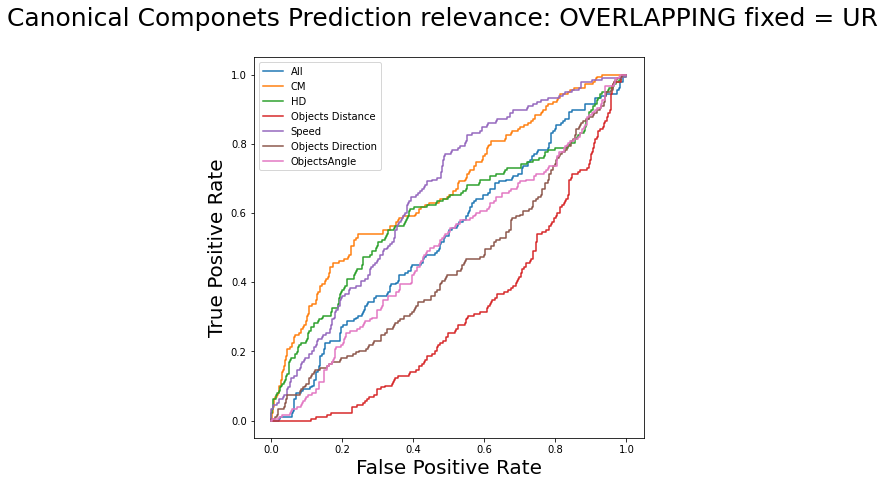

In [20]:
COLOR = (0, 0, 0.1)
def color_conv(color_range):
    return (COLOR[0] + color_range, COLOR[1], COLOR[2]) 

parameters_names = ['CM_x', 'CM_y', 'HD_x', 'HD_y', 'D1', 'D2', 'Speed', 'OHD_x1', 'OHD_y1', 'OHD_x2', 'OHD_y2', 'alpha1','alpha2']
pairs_names = ['All','CM','HD','Objects Distance','Speed','Objects Direction','ObjectsAngle']
figure, axes = plt.subplots()
axes.plot(ROC_fpr_complete,ROC_tpr_complete)
for j in range(len(ROC_fpr)):
    axes.plot(ROC_fpr[j],ROC_tpr[j])#, color=color_conv(j/len(ROC_fpr)), linewidth=3)

axes.set_xlabel('False Positive Rate', fontsize = 20)
axes.set_ylabel('True Positive Rate', fontsize = 20)
axes.legend(pairs_names)

figure.set_size_inches(7,7)

figure.suptitle('Canonical Componets Prediction relevance: '+ task + ' fixed = ' + fixed  , fontsize = 25)

figure_name = figure_path +'cca_componentes_ROC_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_day_'+ f'{day}'  +'.png'
figure.savefig(figure_name)


### The same but for trial by trial

In [21]:
    ###training and testing in different trials
    componets_pairs = [[0,1,2,3,4,5,6,7,8,9,10,11,12,13],[1,2],[3,4],[5,6],[1,7],[8,9,10,11],[12,13]]
    cca_training_list = []
    cca_gnb_training_list = []
    testing_input_list = []
    testing_output_list = []


    ##trial to trail train and test decoder
    Xpreall = activity_list[day].T
    firing_rate = np.mean(Xpreall,axis = 0)*10
    selected_cells = np.where(firing_rate < FR_limit)[0]
    Xpreall = Xpreall[:,selected_cells]

    for trial in range(5):
        
        print('Trial = ' + f'{day*5+trial+1}')
        time0 = int(timeline_list[day][trial*2])
        time1 = int(timeline_list[day][trial*2+1])
        time2 = int(timeline_list[day][trial*2+1]) + 2500

        Xpre = Xpreall[time0:time1,:]     
        tracking_trial = tracking_list[day][:,time0:time1]
        behaviour_trial = behaviour_list[day][time0:time1]
        parameters_trial = parameters_list[day][:,time0:time1]
        index_track = np.logical_and(behaviour_trial>2,behaviour_trial<5)
          
        if index_track.shape[0] > 0:
            
            ybehaviour= behaviour_trial[index_track]
            yparameters = parameters_trial[:,index_track]
            X= Xpre[index_track,:]     

            training_data = int(np.floor(X.shape[0]/10)*8)
            X_train_cca = X[0:training_data,:]
            X_test_cca = X[training_data:,:]
            
            y_train_cca = yparameters[:,0:training_data].T
            y_test_cca = yparameters[:,training_data:].T
            
            y_train_gnb = ybehaviour[0:training_data]
            y_test_gnb = ybehaviour[training_data:]
    
            #save testing data
            testing_input_list.append(X_test_cca)
            testing_output_list.append(y_test_gnb)
                        
            #train cca+classifier
            cca_training_list.append(CCA(n_components = cca_components).fit(X_train_cca, y_train_cca))   
            gnb_cca_training_component = []
            #gnb_cca_training_component.append(GaussianNB().fit(X_transformed,y_train))
            
            for j in range(0,len(componets_pairs)):
                X_transformed = CCA(n_components = cca_components).fit(X_train_cca, y_train_cca).transform(X_train_cca)
                gnb_cca_training_component.append(GaussianNB().fit(X_transformed[:,componets_pairs[j]],y_train_gnb))
            cca_gnb_training_list.append(gnb_cca_training_component)



Trial = 6
Trial = 7
Trial = 8
Trial = 9
Trial = 10


In [22]:
    from sklearn import metrics
    score_matrix_gnb_cca_list = []

    same_trial_list_fpr = []
    same_trial_list_tpr = []

    different_trial_list_fpr = []
    different_trial_list_tpr  = []

    for trial_train in range(5):
        for trial_test in range(5):
            data_transformation = cca_training_list[trial_train].transform(testing_input_list[trial_test])
            ROC_fpr = []
            ROC_tpr = []
            for k in range(0,len(componets_pairs)):
                classifier = cca_gnb_training_list[trial_train][k]
                #score = classifier.predict(data_transformation[:,componets_pairs[k]])
                try:
                    roc_fold = RocCurveDisplay.from_estimator(classifier, data_transformation[:,componets_pairs[k]], testing_output_list[trial_test]) 
                    plt.close()
                except:
                    ROC_fpr.append([])
                    ROC_tpr.append([])
                    pass

#                roc_fold = RocCurveDisplay.from_predictions(score, testing_output_list[j], pos_label = 3) 
                #fpr, tpr, thresholds = metrics.roc_curve(testing_output_list[j], score, pos_label = 3)
                ROC_fpr.append(roc_fold.fpr)
                ROC_tpr.append(roc_fold.tpr)
#                 ROC_fpr.append(fpr)
#                 ROC_tpr.append(tpr)
            if trial_train == trial_test:
                same_trial_list_fpr.append(ROC_fpr)
                same_trial_list_tpr.append(ROC_tpr)
            if trial_train!=trial_test:
                different_trial_list_fpr.append(ROC_fpr)
                different_trial_list_tpr.append(ROC_tpr)          
                       

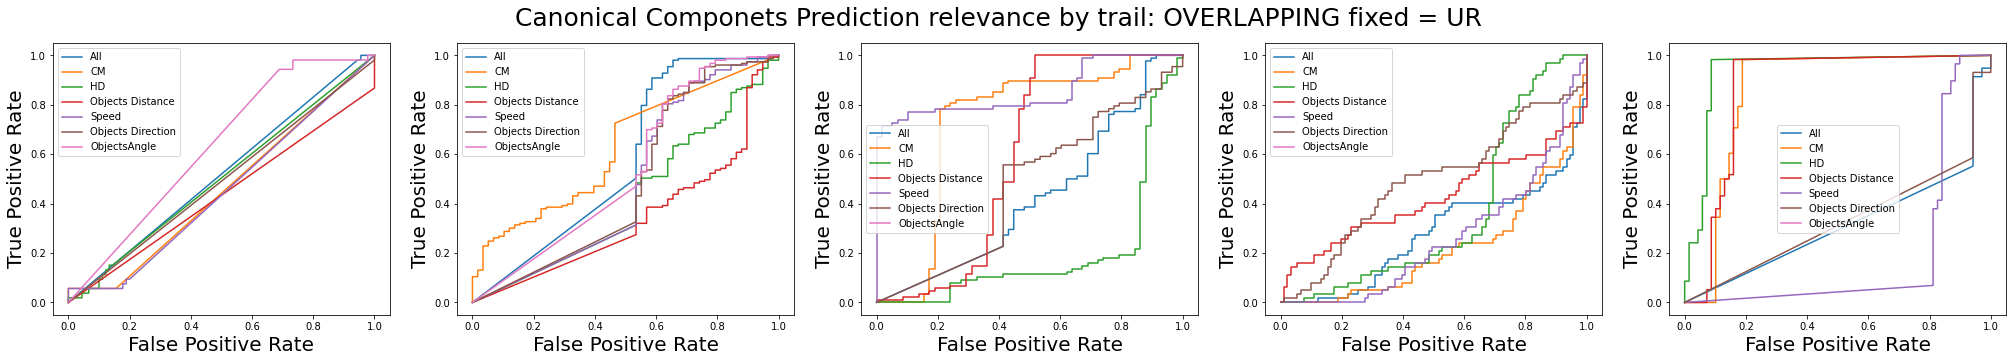

In [23]:
figure, axes = plt.subplots(1,5)

for trial in range(0,len(same_trial_list_fpr)):
    for k in range(0,len(componets_pairs)):
        axes[trial].plot(same_trial_list_fpr[trial][k],same_trial_list_tpr[trial][k])
    axes[trial].set_xlabel('False Positive Rate', fontsize = 20)
    axes[trial].set_ylabel('True Positive Rate', fontsize = 20)
    axes[trial].legend(pairs_names)
    
figure.set_size_inches(35,5)


figure.suptitle('Canonical Componets Prediction relevance by trail: '+ task + ' fixed = ' + fixed  , fontsize = 25)

figure_name = figure_path +'cca_componentes_ROC_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_day_'+ f'{day}'  +'_in_trial.png'
figure.savefig(figure_name)


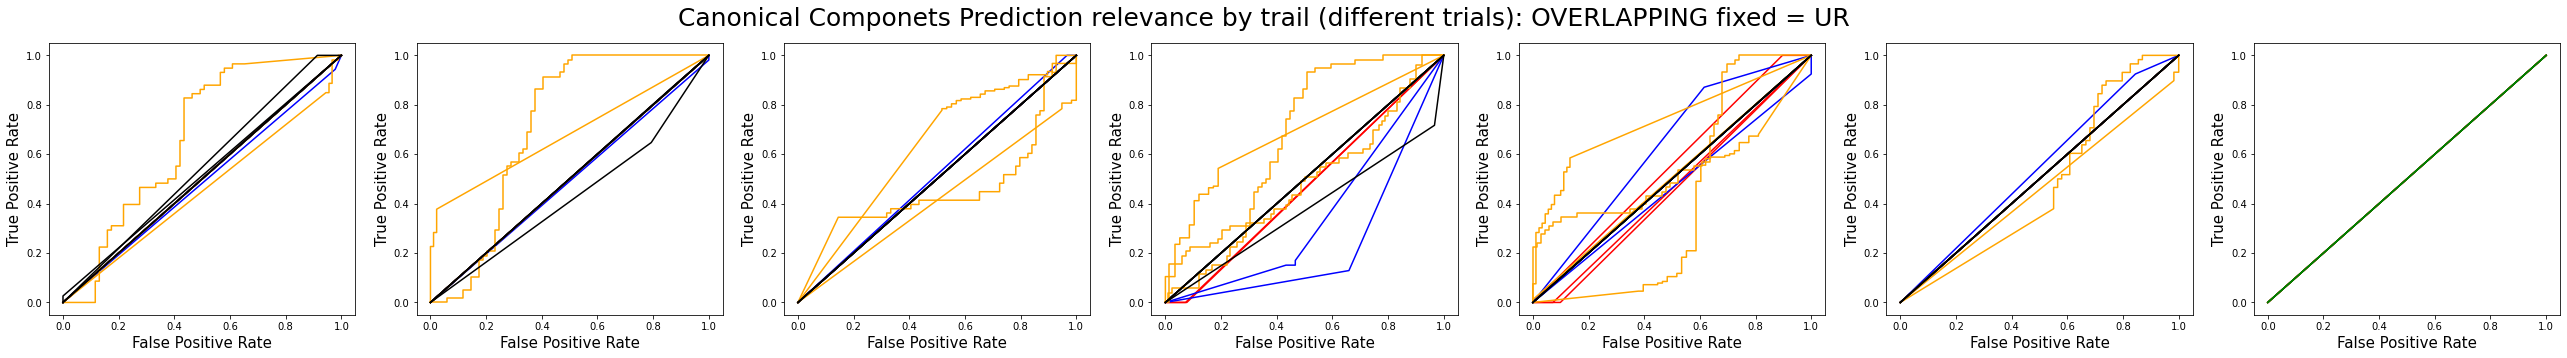

In [24]:
figure, axes = plt.subplots(1,len(componets_pairs))

trial_color = ['r','r','r','r','g','g','g','g','b','b','b','b','orange','orange','orange','orange','k','k','k','k']

for i in range(len(different_trial_list_fpr)):
    for k in range(0,len(componets_pairs)):
        axes[k].plot(different_trial_list_fpr[i][k],different_trial_list_tpr[i][k], trial_color[i])
        axes[k].set_xlabel('False Positive Rate', fontsize = 15)
        
        axes[k].set_ylabel('True Positive Rate', fontsize = 15)
        #axes[trial].legend(pairs_names)

figure.set_size_inches(45,5)

figure.suptitle('Canonical Componets Prediction relevance by trail (different trials): '+ task + ' fixed = ' + fixed  , fontsize = 25)

figure_name = figure_path +'cca_componentes_ROC_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_day_'+ f'{day}'  +'_in_different_trial.png'
figure.savefig(figure_name)
